In [4]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris['data']
y = iris['target']

n_samples, n_features = X.shape

print('Number of samples:', n_samples)
print('Number of features:', n_features)

Number of samples: 150
Number of features: 4


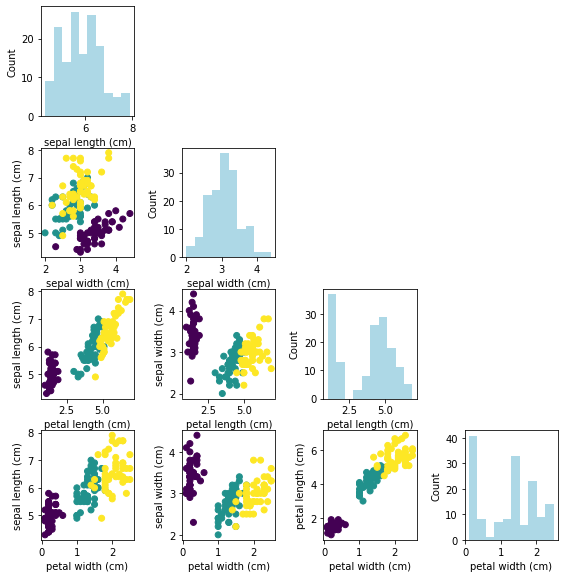

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=n_features, ncols=n_features, figsize= (8, 8))
fig.tight_layout()

names = iris.feature_names

for i, j in zip(*np.triu_indices_from(ax, k=1)):
    ax[j, i].scatter(X[:, j], X[:, i], c = y)
    ax[j, i].set_xlabel(names[j])
    ax[j, i].set_ylabel(names[i])
    ax[i, j].set_axis_off()

for i in range(n_features):
    ax[i, i].hist(X[:, i], color = 'lightblue')
    ax[i, i].set_ylabel('Count')
    ax[i, i].set_xlabel(names[i])

In [8]:
def mean(x): # np.mean(X, axis = 0)  
    return sum(x)/len(x)  

def std(x): # np.std(X, axis = 0)
    return (sum((i - mean(x))**2 for i in x)/len(x))**0.5

def Standardize_data(X):
    return (X - mean(X))/std(X)

X_std = Standardize_data(X)

def covariance(x): 
    return (x.T @ x)/(x.shape[0]-1)

cov_mat = covariance(X_std) # np.cov(X_std.T)

In [9]:
from numpy.linalg import eig

# Eigendecomposition of covariance matrix
eig_vals, eig_vecs = eig(cov_mat) 

# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs = eig_vecs*signs[np.newaxis,:]
eig_vecs = eig_vecs.T

print('Eigenvalues \n', eig_vals)
print('Eigenvectors \n', eig_vecs)

Eigenvalues 
 [2.93808505 0.9201649  0.14774182 0.02085386]
Eigenvectors 
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]
 [ 0.71956635 -0.24438178 -0.14212637 -0.63427274]
 [-0.26128628  0.12350962  0.80144925 -0.52359713]]


In [10]:
# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

print(eig_pairs)

[(2.9380850501999918, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654])), (0.920164904162487, array([0.37741762, 0.92329566, 0.02449161, 0.06694199])), (0.14774182104494785, array([ 0.71956635, -0.24438178, -0.14212637, -0.63427274])), (0.020853862176462023, array([-0.26128628,  0.12350962,  0.80144925, -0.52359713]))]


In [11]:
# Select top k eigenvectors
k = 2
W = eig_vecs_sorted[:k, :] # Projection matrix

print(W.shape)

(2, 4)


Explained variance: [72.96 22.85  3.67  0.52]
Cumulative explained variance: [ 72.96  95.81  99.48 100.  ]


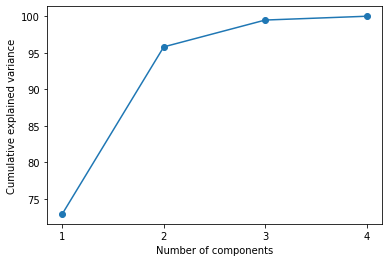

In [12]:
eig_vals_total = sum(eig_vals)
explained_variance = [(i / eig_vals_total)*100 for i in eig_vals_sorted]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

print('Explained variance: {}'.format(explained_variance))
print('Cumulative explained variance: {}'.format(cum_explained_variance))

plt.plot(np.arange(1,n_features+1), cum_explained_variance, '-o')
plt.xticks(np.arange(1,n_features+1))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.show()

In [13]:
X_proj = X_std.dot(W.T)

print(X_proj.shape)

(150, 2)


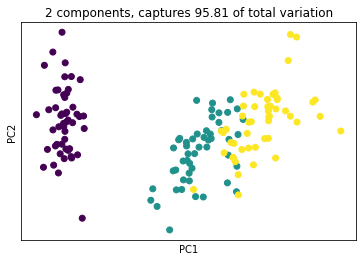

In [14]:
plt.scatter(X_proj[:, 0], X_proj[:, 1], c = y)
plt.xlabel('PC1'); plt.xticks([])
plt.ylabel('PC2'); plt.yticks([])
plt.title('2 components, captures {} of total variation'.format(cum_explained_variance[1]))
plt.show()

In [15]:
class MyPCA:
    
    def __init__(self, n_components):
        self.n_components = n_components   
        
    def fit(self, X):
        # Standardize data 
        X = X.copy()
        self.mean = np.mean(X, axis = 0)
        self.scale = np.std(X, axis = 0)
        X_std = (X - self.mean) / self.scale
        
        # Eigendecomposition of covariance matrix       
        cov_mat = np.cov(X_std.T)
        eig_vals, eig_vecs = np.linalg.eig(cov_mat) 
        
        # Adjusting the eigenvectors that are largest in absolute value to be positive    
        max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
        signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
        eig_vecs = eig_vecs*signs[np.newaxis,:]
        eig_vecs = eig_vecs.T
       
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        eig_vals_sorted = np.array([x[0] for x in eig_pairs])
        eig_vecs_sorted = np.array([x[1] for x in eig_pairs])
        
        self.components = eig_vecs_sorted[:self.n_components,:]
        
        # Explained variance ratio
        self.explained_variance_ratio = [i/np.sum(eig_vals) for i in eig_vals_sorted[:self.n_components]]
        
        self.cum_explained_variance = np.cumsum(self.explained_variance_ratio)

        return self

    def transform(self, X):
        X = X.copy()
        X_std = (X - self.mean) / self.scale
        X_proj = X_std.dot(self.components.T)
        
        return X_proj
# ---------------------------------------------------------
my_pca = MyPCA(n_components = 2).fit(X)

print('Components:\n', my_pca.components)
print('Explained variance ratio from scratch:\n', my_pca.explained_variance_ratio)
print('Cumulative explained variance from scratch:\n', my_pca.cum_explained_variance)

X_proj = my_pca.transform(X)
print('Transformed data shape from scratch:', X_proj.shape)

Components:
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]
Explained variance ratio from scratch:
 [0.7296244541329989, 0.22850761786701754]
Cumulative explained variance from scratch:
 [0.72962445 0.95813207]
Transformed data shape from scratch: (150, 2)
